# Code Associated with Research Question 1

__Research Question 1__ <br>
"Does theta activity occur during memory recall and memory encoding in the experiment?"

In [1]:
# common imports
import numpy as np
import os
import pickle
import json
import pandas
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.ndimage import zoom, gaussian_filter # smoothing

# time-frequency analysis
from scipy import signal
from scipy.fftpack import next_fast_len

# statistics
from scipy import stats, ndimage
import skimage
import mne # for permutation tests

# own libraries
import neuropsy as npsy
import neuropsy.analysis as npsya
import neuropsy.statistics as npsystat

In [3]:
#********** PARAMETERS **********#
path_data                   = '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/data/preprocessed'
path_results                = f'/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
subject_ids                 = npsy.utils.get_subject_ids_from_path(path_data)

postfix_load                = 'preprocessed'
postfix_save                = 'q1'

# analysis parameters
stimulus_list               = ['Picture Shown', 'Picture Placed']
tmin                        = -.5                   # time before stimulus
tmax                        = 2                     # time after stimulus
baseline                    = (-1, -0.5)              # time period from before stimulus to use for baseline correction
baseline_method             = 'mean'                # basline correction method (see neuropsy.preprocessing)

# wavelet parameters
fs                          = 512
t_wl                        = np.arange(-4, 4+1/fs, 1/fs) # long enough time to capture the wavelet for given f and n
frequencies                 = np.arange(2, 13, 1)
cycles                      = [8, 7, 6, 6, 5, 5, 5, 4, 4, 3, 3]
n_half_wavelet              = len(t_wl) // 2

# plot parameters
timepoints                  = np.arange(0, 1280, 1)
xticks                      = [0, 255, 511, 767, 1023, 1279]
xlabels                     = ["- 0.5 s", "stim", "0.5 s", "1 s", "1.5 s", "2 s"]
frequencies_plot            = np.insert(frequencies.astype(float), [0, len(frequencies)], [1.5, 12.5]) # define custom y ticks across frequencies but exclude first and last frequency labels as they the ticks are only for plotting purposes
yticks                      = frequencies_plot
ylabels                     = [int(frequencies_plot[i]) if i > 0 and i < len(frequencies_plot)-1 else "" for i in range(len(frequencies_plot))]

# set up directory for saving results
if not os.path.exists(path_results):
    os.makedirs(path_results)
    os.makedirs(f"{path_results}/data")

# 1. Time-frequency Power Analysis 

General info
- Analyse Entire hippocampus
- Manual convolution
- Two stimulus; onset is "picture shown" (memory recall) and offset is "picture placed" (memory encoding)
- Baseline correct within trials (-1 s to -0.5 s before onset)

Processing info
- Trials with NaNs are identified in a previous preprocessing step and removed from the experiment dataframe
- Outliers trials are identified in a previous preprocessing step and excluded here during the analysis
- IED timepoints for each contact are identified in a previous preprocessing step and trials with IEDs are exluded here during the analysis

Steps:
1. Iterate over all subjects
2. Select contacts in the hippocampus
3. Compute time-frequency power for the channels in each subject
4. Exlude trials with IEDs
5. Cut trial epochs for each stimulus and the corresponding baseline period
6. Baseline correct trial epochs
7. Average time-frequency power across trials to obtain channel average
8. Average time-frequency power across channels to obtain subject average
9. Average all time-frequency power across all subjects to obtain total average

### 1.1 Decide Center Frequencies and Number of Cycles for Complex Morelet Wavelet

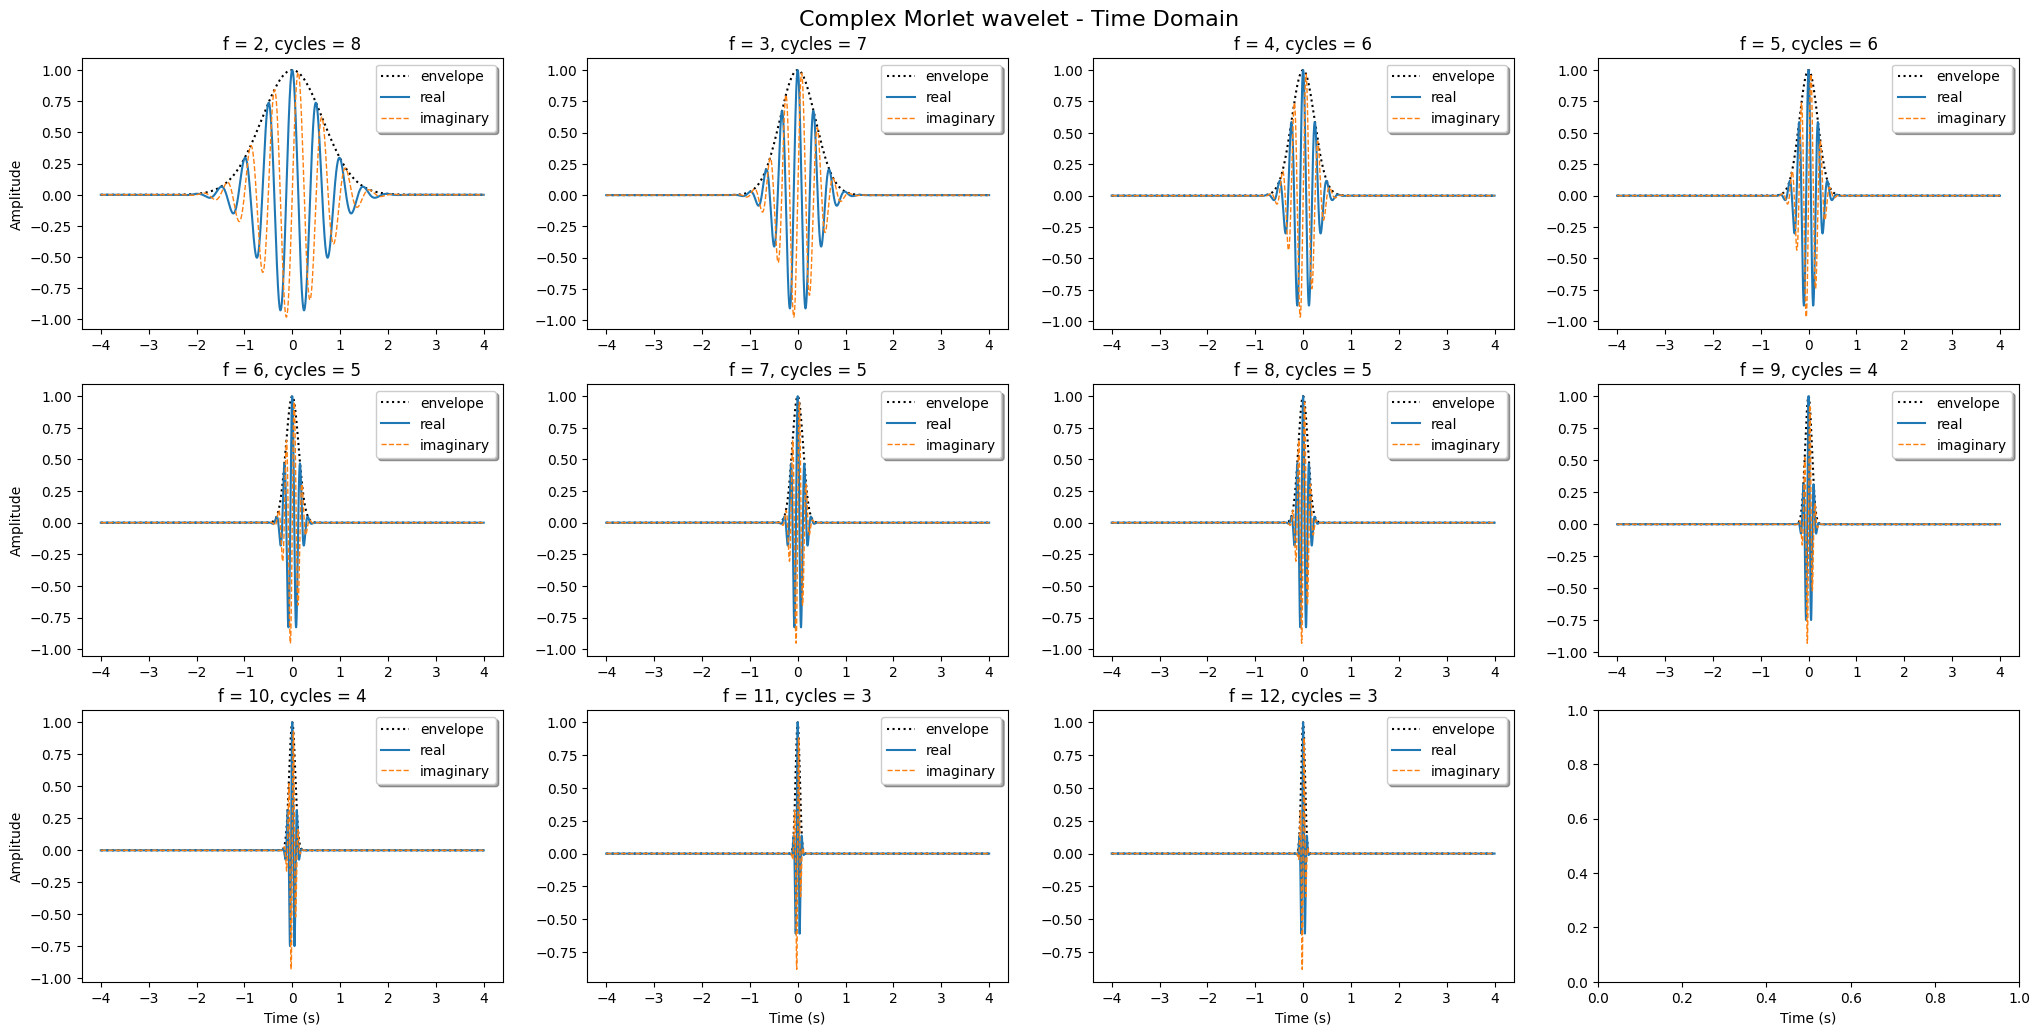

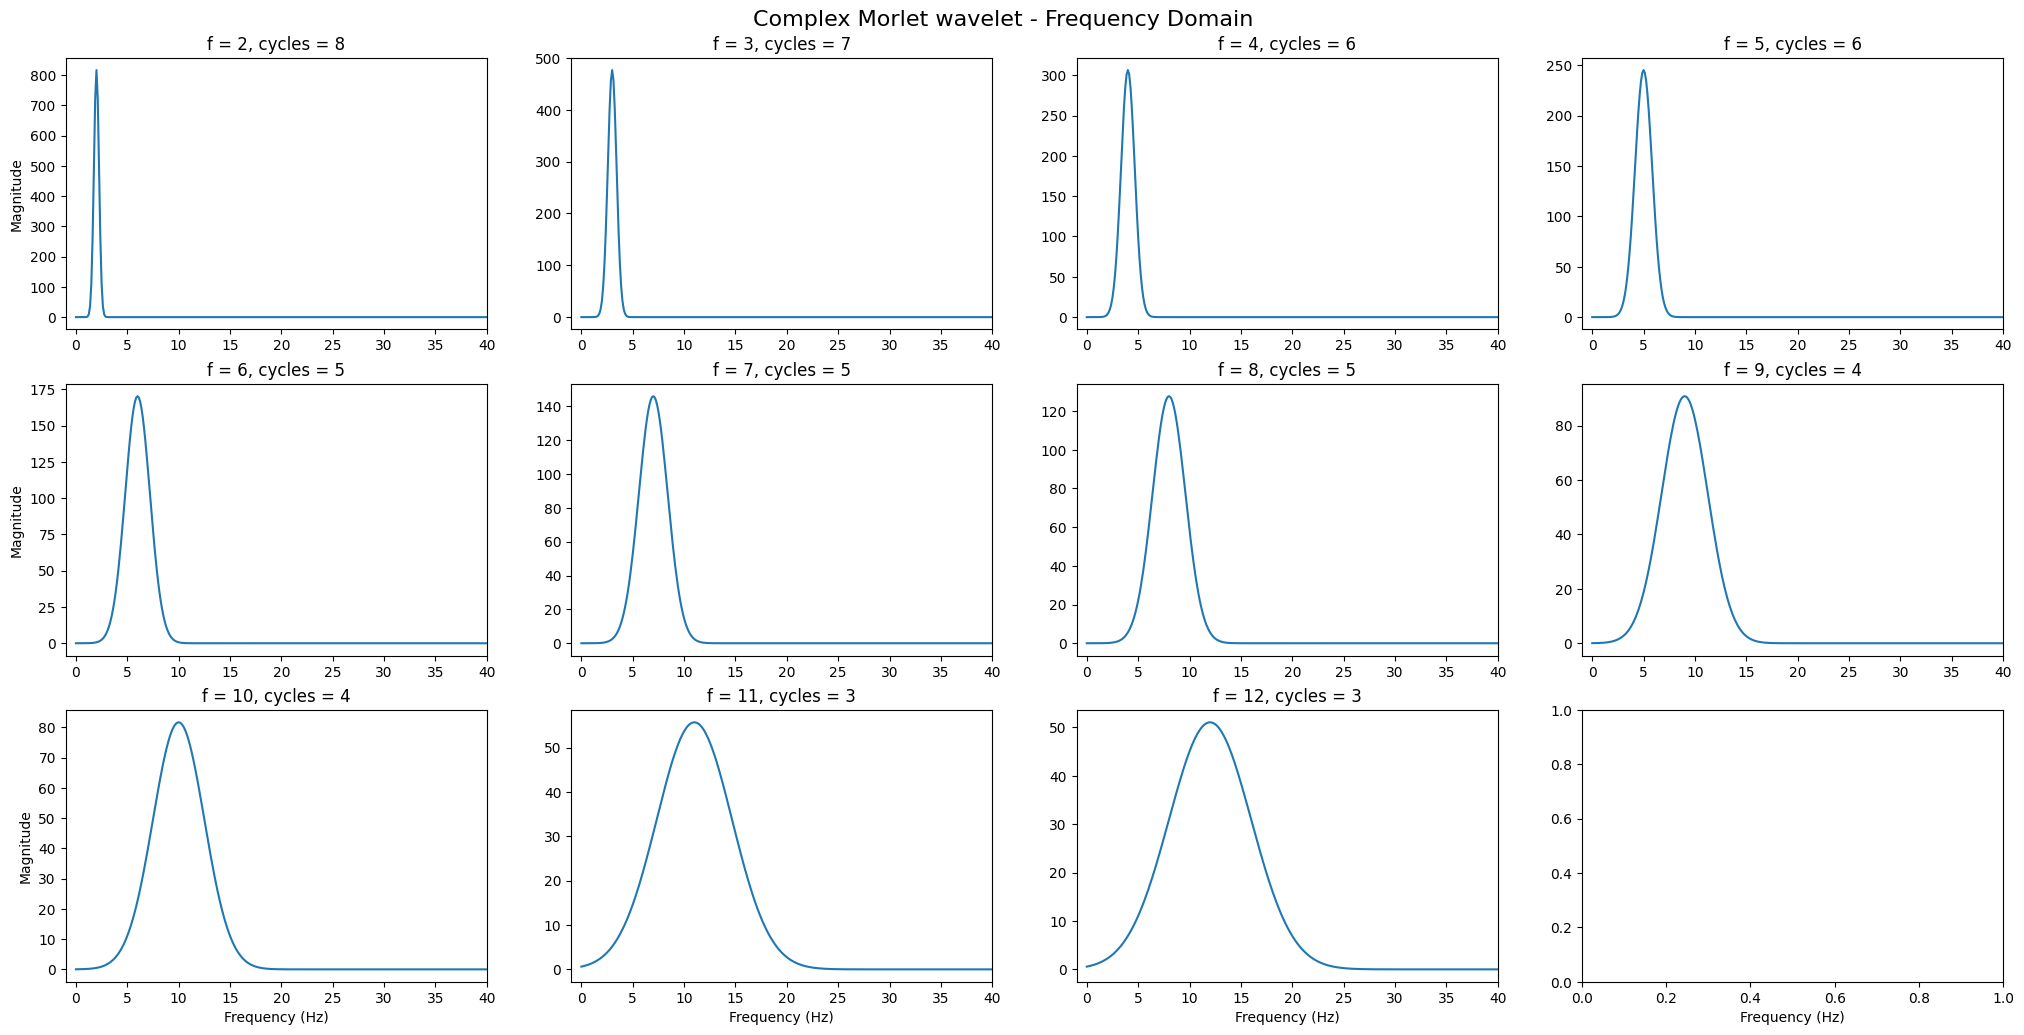

In [3]:
def plot_wavelets(frequencies, cycles, t_wl, fs):
    
    nrows = np.floor(np.sqrt(len(frequencies))).astype(int)
    
    fig, ax = plt.subplots(figsize=(25, nrows*4), nrows=nrows, ncols=4)#, sharex=True, sharey=True)
    fig2, ax2 = plt.subplots(figsize=(25, nrows*4), nrows=nrows, ncols=4)#, sharex=True, sharey=True)
    ax = ax.flatten()
    ax2 = ax2.flatten()

    wavelet_funcs = {}
    for i, (f, n) in enumerate(zip(frequencies, cycles)):

        # create complex Morlet wavelet
        wavelet, gauss_env = npsya.morlet(f, n, t_wl, return_gaussian=True)
        wavelet_funcs[f] = wavelet
        
        # plot wavelet and gaussian envelope
        ax[i].plot(t_wl, gauss_env, ':', label='envelope', color='black')
        ax[i].plot(t_wl, wavelet.real, label='real')
        ax[i].plot(t_wl, wavelet.imag, label='imaginary', linestyle='--', linewidth=1.)
        ax[i].set_title(f'f = {f}, cycles = {n}')
        if (i % 4 == 0) or (i % 8 == 0) or (i % 12 == 0) or (i % 16 == 0):
            ax[i].set_ylabel('Amplitude')
        if i == 0:
            ax[-1].set_xlabel('Time (s)')
            ax[-2].set_xlabel('Time (s)')
            ax[-3].set_xlabel('Time (s)')
            ax[-4].set_xlabel('Time (s)')
        ax[i].legend(loc='upper right', shadow=True)
        
        # plot frequency spectrum
        xf, y = npsya.compute_fft(wavelet, fs, output='mag')
        ax2[i].plot(xf, y)
        ax2[i].set_title(f'f = {f}, cycles = {n}')
        if (i % 4 == 0) or (i % 8 == 0) or (i % 12 == 0) or (i % 16 == 0):
            ax2[i].set_ylabel('Magnitude')
        if i == 0:
            ax2[-1].set_xlabel('Frequency (Hz)')
            ax2[-2].set_xlabel('Frequency (Hz)')
            ax2[-3].set_xlabel('Frequency (Hz)')
            ax2[-4].set_xlabel('Frequency (Hz)')
        # ax2[i, j].set_yscale('log')
        ax2[i].set_xlim([-1, 40])
        # ax2[i, j].set_ylim([40, 120])
            
    fig.suptitle('Complex Morlet wavelet - Time Domain', fontsize=16, y=.92)
    fig2.suptitle('Complex Morlet wavelet - Frequency Domain', fontsize=16, y=.92)
    plt.show()
    
    
# ********* TEST FUNCTION ********* #
fs                          = 512
t_wl                        = np.arange(-4, 4+1/fs, 1/fs) # long enough time to capture the wavelet for given f and n

# OLD
# frequencies                 = np.arange(2, 32, 2)
# cycles                      = np.insert(np.flipud(np.arange(3, 13, 1)), [-1, -2, -3, -4, -5], [3, 4, 5, 6, 7])

# CURRENT
# frequencies                 = np.arange(2, 13, 1)
# cycles                      = [8, 7, 7, 6, 6, 5, 5, 4, 4, 3, 3]

# TEST
frequencies                 = np.arange(2, 13, 1)
# cycles                      = [8, 7, 7, 6, 6, 5, 5, 4, 4, 3, 3]
# cycles = [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]

plot_wavelets(frequencies, cycles, t_wl, fs)

### 1.2 Power Analysis

for each subject
- select channels in hippocampus  (head/body/tail)
- remove outlier trials
- check trial durations (should not be too short or too close between trials)
- get trial indices (time points) in iEEG signal
- fft of each channel
- cwt of each channel (2-12 Hz)
- cut signal according to trial time points
- baseline correction of each trial individually
- save time-frequency results
- save analysis info

In [4]:
for stimulus in stimulus_list:
    print(f"Starting analysis for stimulus {repr(stimulus)}...")

    # save general analysis info (will be saved as json file in the end)
    dict_analysis_info = {}
    dict_analysis_info['general'] = {}
    dict_analysis_info['general']['stimulus'] = stimulus
    dict_analysis_info['general']['tmin'] = tmin
    dict_analysis_info['general']['tmax'] = tmax
    dict_analysis_info['general']['baseline'] = baseline
    dict_analysis_info['general']['baseline_method'] = baseline_method
    dict_analysis_info['general']['wavelet'] = {'frequencies': frequencies.tolist(), 'cycles': cycles.tolist() if isinstance(cycles, np.ndarray) else cycles}

    # time-frequency result dictionary {subject_id: {channel name: {trial identifier: np.2darray}}}
    dict_tfr_power_results = {s: {} for s in subject_ids}

    #********** START ANALYSIS **********#
    for subject_id in subject_ids:
        
        # initialise variables
        trial_names_outliers                = None
        labels_outliers                     = None
        dict_outliers                       = {}
        trial_names_too_short               = None
        trial_names_too_close               = None
        labels_too_short                    = None
        labels_too_close                    = None
        dict_too_short                      = {}
        dict_too_close                      = {}
        
        
        start_time_sub = time.time()
        print(f"\tStarting subject {subject_id}...")

        #********** LOAD SUBJECT DATA **********# 
        data = npsy.DataHandler(path=path_data, subject_id=subject_id, exp_phase=2, fs=512, verbose=False)
        data.load(load_saved=True, postfix=postfix_load)
        
        # subtract total mean from each channel to remove DC bias
        print("\tRemoving DC bias from iEEG data...")
        total_mean = np.mean(data.ieeg)
        for i in range(data.ieeg.shape[0]):
            data.ieeg[i, :] = data.ieeg[i, :] - total_mean
            data.ieeg[i, :] = signal.detrend(data.ieeg[i, :])
            
        #********** SELECT CHANNELS TO INCLUDE IN ANALYSIS **********# 
        print(f"\tSelecting channels in hippocampus...")
        ch_names = data.df_chan.loc[data.df_chan['HC_Subfields'].str.contains('HP_head|HP_body|HP_tail', case=True, na=False)].name.to_list()
        # check that there are channels in the hippocampal subfield for this subject, otherwise skip
        if len(ch_names) > 0:
            data.select_channels(ch_names=np.ravel(ch_names), inplace=True)
            print(f"\tSelected {len(ch_names)} channels in hippocampus.")
        else:
            print(f"\tNo channels in hippocampus.")
        
        #********** REMOVE OUTLIERS (TRIALS WITH TOO HIGH REACTION TIME)  **********# 
        print("\tRemoving outliers from experiment dataframe...")
        idx_outliers = data.df_exp[data.df_exp['outlier'] == True]['outlier'].index.to_list()
        if len(idx_outliers) > 0:
            trial_names_outliers    = data.df_exp[data.df_exp['outlier'] == True]['Trial Identifier'].to_list()
            data.df_exp = data.df_exp.drop(idx_outliers).reset_index(drop=True)
        else:
            print("\tNo outliers in experiment dataframe.")

        # [INFO] need to make sure trials have enough time points for the chosen tmax
        #********** CHECK TRIAL DURATIONS **********# 
        print("\tChecking trial durations...")
        idx_too_short, idx_too_close = npsya.check_trials(df=data.df_exp, tmin=tmin, tmax=tmax, baseline=baseline)
        idx_drop = np.unique(np.concatenate((idx_too_short, idx_too_close))).astype(int).tolist()
        # trials with too few time points
        if len(idx_too_short) > 0:
            trial_names_too_short  = data.df_exp.loc[idx_too_short, 'Trial Identifier'].to_list()
        else:
            print("\tNo trials are too short.")
        # trials too close to other trials
        if len(idx_too_close) > 0:
            trial_names_too_close  = data.df_exp.loc[idx_too_close, 'Trial Identifier'].to_list()
        else:
            print("\tNo trials are too close.")

        #********** CREATE MNE RAW OBJECT **********#
        # - the raw object will only contain the previously selected channels
        data.create_mne_raw()
        

        #********** GET TRIAL TIME POINTS (INDICES) AND TRIAL IDENTIFIERS (NAMES) **********#
        # - need trial indices from experiment dataframe
        # - also need the corresponding trial indices for the baseline (picture shown)
        # - also need to extract the trial identifiers (names) to keep track of trials in the resulting time-frequency power data
        print("\tGetting trial indices...")
        dict_trial_indices = {**{'stimulus': None}, **{'baseline': None}, **{'names': None}}
        # get the trial indices
        idx_stimulus                        = data.df_exp[f'Mark for {stimulus}'].to_numpy().astype(int)
        idx_baseline                        = data.df_exp['Mark for Picture Shown'].to_numpy().astype(int)
        # save indices
        dict_trial_indices["stimulus"]      = idx_stimulus
        dict_trial_indices["baseline"]      = idx_baseline
        # get the trial identifiers (names) for the condition
        trial_names                         = data.df_exp['Trial Identifier'].to_numpy().astype(str)
        # save trial identifiers
        dict_trial_indices["names"]         = trial_names


        #********** TIME-FREQUENCY ANALYSIS **********#
        # info
        dict_n_trials_kept = None
        dict_n_trials_ieds = None
        
        if len(ch_names) > 0:
            
            # info
            dict_n_trials_kept = {**{f'{ch}': {'trial_identifiers': [], 'count': 0} for ch in ch_names}, **{'total': 0}}
            dict_n_trials_ieds = {**{f'{ch}': {'trial_identifiers': [], 'count': 0} for ch in ch_names}, **{'total': 0}}
            
            # CHANNEL:
            #  - FFT of entire channel signal
            #  - CWT for each frequency and cycle
            #  - store power in dB for each frequency
            #  - this is done once per channel, then afterwards each trial is considered independently during TRIAL loop
            #    - this is done to save time as the CWT is the most time-consuming part
            for ch in ch_names:
                start_time_ch = time.time()
                print(f"\t\tStarting channel {ch}...")
                
                # use the whole channel signal for computing time-frequency representation
                ch_signal = data.raw.get_data(ch)[0]
                
                # ********* FFT of CHANNEL ********* #
                n_conv      = len(t_wl) + len(ch_signal) - 1
                n_conv_fast = next_fast_len(n_conv)
                signal_fft  = np.fft.fft(ch_signal, n_conv_fast)
                
                # initialise output data for continuous wavelet transform
                tf_data = np.zeros((len(frequencies), len(ch_signal)))
                
                # ********* CWT ********* #
                for i, (f, n) in enumerate(zip(frequencies, cycles)):
                    
                    # [INFO] - print current wavelet parameters
                    # print(f"creating wavelet with parameters: f = {f}, n = {n}...")
                    
                    # create wavelet
                    wavelet = npsya.morlet(f, n, t_wl)
                    
                    # fft of wavelet
                    # note:
                    #   output must match the length of the signal_fft in order to multiply in the frequency domain
                    wavelet_fft = np.fft.fft(wavelet, n=n_conv_fast)
                    
                    # convolution
                    coefficients = np.fft.ifft(signal_fft * wavelet_fft, n=n_conv_fast)
                    coefficients = coefficients[:n_conv] # remove padding from next_fast_len
                    coefficients = coefficients[n_half_wavelet:-n_half_wavelet]
                    
                    # convert to power in dB
                    tf_power = 10 * np.log10(np.abs(coefficients)**2)
                    
                    # store result for frequency
                    tf_data[i, :] = tf_power
                    
                # clean up
                del ch_signal, signal_fft, wavelet, wavelet_fft, coefficients, tf_power
                    
                # TRIAL:
                #  - continuous wavelet transform result is stored in tf_data (in dB) from above
                #  - now we need to consider each trial independently
                #  - loop over trials
                #  - baseline correction is done for each trial separately
                dict_tfr_power_results[subject_id][ch] = {}
                for (i_stimulus, i_baseline, trial_id) in zip(dict_trial_indices['stimulus'], 
                                                              dict_trial_indices['baseline'], 
                                                              dict_trial_indices['names']):
                    start_time_trial = time.time()
                    
                    # get start and stop timepoints for trial period and baseline period
                    i_tmin = int(i_stimulus + int(tmin * fs))
                    i_tmax = int(i_stimulus + int(tmax * fs))
                    b_tmin = int(i_baseline + int(baseline[0] * fs))
                    b_tmax = int(i_baseline + int(baseline[1] * fs))
                    
                    #********** CHECK TRIAL FOR IEDs **********# 
                    # - if there are IEDs in the trial, skip it and exclude it from the analysis
                    # - if there are IEDs in the baseline, skip it and exclude it from the analysis
                    if npsya.check_period_for_ieds(ch, data.df_ied, i_tmin, i_tmax):
                        print(f"\t\t\t\tSkipping trial {trial_id} due to IEDs in trial period.")
                        dict_n_trials_ieds[ch]['trial_identifiers'].append(trial_id)
                        dict_n_trials_ieds[ch]['count'] += 1
                        dict_n_trials_ieds['total']     += 1
                        continue
                    if npsya.check_period_for_ieds(ch, data.df_ied, b_tmin, b_tmax):
                        print(f"\t\t\t\tSkipping trial {trial_id} due to IEDs in baseline period.")
                        dict_n_trials_ieds[ch]['trial_identifiers'].append(trial_id)
                        dict_n_trials_ieds[ch]['count'] += 1
                        dict_n_trials_ieds['total']     += 1
                        continue
                    
                    # get power for trial period
                    power_trial = tf_data[:, i_tmin:i_tmax]
                    # get power for baseline period
                    power_baseline = tf_data[:, b_tmin:b_tmax]
                    # baseline correction
                    tf_data[:, i_tmin:i_tmax] = npsya.apply_baseline(epoch_power=power_trial, baseline_power=power_baseline, method=baseline_method)
                    
                    # store time-frequency power result for trial
                    dict_tfr_power_results[subject_id][ch][trial_id] = tf_data[:, i_tmin:i_tmax]
                    
                    # info
                    dict_n_trials_kept[ch]['trial_identifiers'].append(trial_id)
                    dict_n_trials_kept[ch]['count'] += 1
                    dict_n_trials_kept['total']     += 1
                    
                    # print(f"\t\t\t\tTrial {trial_id} done in {(time.time() - start_time_trial)*1000:.2f} milliseconds")
                    
                # clean up
                del power_trial, power_baseline
                    
                print(f"\t\tChannel {ch} done - {time.time() - start_time_ch:.2f} seconds")
        # no channels
        else:
            # remove subject from results if there are no channels in the hippocampus
            dict_tfr_power_results.pop(subject_id)
            print(f"\tNo channels in hippocampus for subject {subject_id}.")
            

        # save analysis info for subject
        tmp_dict_outliers           = {**{'count': len(idx_outliers)}, **{'indices': idx_outliers}, **{'trial_identifiers': trial_names_outliers}}
        tmp_dict_too_short          = {**{'count': len(idx_too_short)}, **{'indices': idx_too_short}, **{'trial_identifiers': trial_names_too_short}}
        tmp_dict_too_close          = {**{'count': len(idx_too_close)}, **{'indices': idx_too_close}, **{'trial_identifiers': trial_names_too_close}}
        
        dict_analysis_info[f'subject {subject_id}'] = {
            'channels': ch_names if len(ch_names) > 0 else None,
            'trials_kept': dict_n_trials_kept if len(ch_names) > 0 else None,
            'trials_dropped': {
                'outliers': tmp_dict_outliers,
                'too_short': tmp_dict_too_short,
                'too_close': tmp_dict_too_close,
                'ieds': dict_n_trials_ieds
            } if len(ch_names) > 0 else None
        }
        
        # update experiment dataframe
        data.df_exp = data.df_exp.drop(idx_drop).reset_index(drop=True)
        
        # save updated dataframes with new postfix
        data.save(postfix=postfix_save)
        
        # clean up
        del dict_n_trials_kept, dict_n_trials_ieds, tmp_dict_outliers, tmp_dict_too_short, tmp_dict_too_close
        
        print(f"\tSubject {subject_id} done - {time.time() - start_time_sub:.2f} seconds")
        
        # break
            

    #********** SAVE RESULTS **********#
    filename = f"{path_results}/data/1.2 tfr_power_results_{stimulus}.pkl"
    with open(filename, 'wb') as f:
        print(f"\tSaving results as {repr(filename)}...")
        pickle.dump(dict_tfr_power_results, f)
        print("\tDone")
    #********** SAVE ANALYSIS INFO **********#
    filename = f"{path_results}/data/1.2 tfr_analysis_info_{stimulus}.json"
    with open(filename, 'w') as f:
        print(f"\tSaving analysis info as {repr(filename)}...")
        json.dump(dict_analysis_info, f)
        print("\tDone")
        
    # clean up
    del dict_tfr_power_results, dict_analysis_info

Starting analysis for stimulus 'Picture Shown'...
	Starting subject 03...
	Removing DC bias from iEEG data...
	Selecting channels in hippocampus...
	Selected 6 channels in hippocampus.
	Removing outliers from experiment dataframe...
	Checking trial durations...
	No trials are too close.
Creating RawArray with float64 data, n_channels=6, n_times=823114
    Range : 0 ... 823113 =      0.000 ...  1607.643 secs
Ready.
	Getting trial indices...
		Starting channel B' 01...
				Skipping trial 46-1 due to IEDs in trial period.
				Skipping trial 25-1 due to IEDs in trial period.
				Skipping trial 4-1 due to IEDs in trial period.
				Skipping trial 30-1 due to IEDs in trial period.
				Skipping trial 24-1 due to IEDs in trial period.
				Skipping trial 40-1 due to IEDs in trial period.
				Skipping trial 21-1 due to IEDs in baseline period.
				Skipping trial 10-1 due to IEDs in trial period.
				Skipping trial 27-1 due to IEDs in trial period.
				Skipping trial 42-2 due to IEDs in trial peri

### 1.3 Load Previous Results

In [8]:
# [IMPORTANT] load data in this cell once to avoid re-running the heavy loading process. 
stimulus = 'Picture Placed'
filename = f"{path_results}/data/1.2 tfr_power_results_{stimulus}.pkl"

# load previously computed time-frequency power for all subjects
with open(filename, 'rb') as f:
    dict_tfr_power_results = pickle.load(f)

# get conditions and subject ids from the loaded results dictionary
subject_ids = list(dict_tfr_power_results.keys())

#################### GET AVERAGES AS DICT ####################
# compute channel average (average each channel across all trials)
dict_tfr_power_results_chan_avg = {s: {} for s in subject_ids}
for subject_id in subject_ids:
    for ch in dict_tfr_power_results[subject_id].keys():
        dict_tfr_power_results_chan_avg[subject_id][ch] = np.mean(list(dict_tfr_power_results[subject_id][ch].values()), axis=0)
            
# compute subject average (average each subject across all channels)
dict_tfr_power_results_subj_avg = {s: {} for s in subject_ids}
for subject_id in subject_ids:
    dict_tfr_power_results_subj_avg[subject_id] = np.mean(list(dict_tfr_power_results_chan_avg[subject_id].values()), axis=0)
        
# compute total average (average across all subjects)
dict_tfr_power_results_total_avg = None
dict_tfr_power_results_total_avg = np.mean(list(dict_tfr_power_results_subj_avg.values()), axis=0)

#################### GET AVERAGES AS ARRAY ####################
# get time-frequency shape
n_frequencies   = dict_tfr_power_results_total_avg.shape[0]
n_timepoints    = dict_tfr_power_results_total_avg.shape[1]

# create array for subject averages
arr_tfr_power_results_subj_avg                  = np.zeros((len(subject_ids), n_frequencies, n_timepoints))
for i, subject_id in enumerate(subject_ids):
    dict_tfr_power_results_subj_avg[subject_id] = np.mean(list(dict_tfr_power_results_chan_avg[subject_id].values()), axis=0)
    arr_tfr_power_results_subj_avg[i]           = dict_tfr_power_results_subj_avg[subject_id]
    
# create array for total average
arr_tfr_power_results_total_avg                 = np.mean(arr_tfr_power_results_subj_avg, axis=0)

# clean up to save memory
del dict_tfr_power_results

### 1.4 Visualise Time-Frequency Representation - Channel Average

plot each channel separately for each subject, plot shows the average across trials.

In [9]:
custom_cbar = True

for subject_id in subject_ids:
    for ch in list(dict_tfr_power_results_chan_avg[subject_id].keys()):
        
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 5), layout='compressed')
            
        im = ax.imshow(
            dict_tfr_power_results_chan_avg[subject_id][ch],
            aspect='auto',
            extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
            origin='lower', 
            vmax=np.max(dict_tfr_power_results_chan_avg[subject_id][ch]) if custom_cbar else 3,
            vmin=-np.max(dict_tfr_power_results_chan_avg[subject_id][ch]) if custom_cbar else -3,
            cmap='RdBu_r',
            interpolation='hanning')
        ax.set_title(f'{ch}', fontsize=12)
        ax.set_ylabel('Frequency (Hz)', fontsize=11) # only set ylabel for left most plots
        ax.set_yticks(yticks, ylabels, fontsize=10)
        ax.set_xticks(xticks, xlabels, rotation=0, fontsize=10)
        
        # add line at onset and offset
        ax.axvline(x=255, color='black', linestyle='--', linewidth=1.)
        
        # add colorbar
        cbar = plt.colorbar(im, ax=ax, shrink=0.70, pad=0.01, orientation="vertical")
        cbar.ax.set_ylabel("dB change from baseline", rotation=270, labelpad=15, fontsize=11)
        fig.suptitle(f"Hippocampus, Subject {subject_id}, Channel Average ({stimulus})", fontsize=12, y=1.06, x=.49)
        
        full_save_path = f"{path_results}/1.4 {stimulus}_tfr_sub{subject_id}_{ch}_power.png"
        fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure for subject {subject_id} at {repr(full_save_path)}")
        plt.close(fig)
        # plt.show()
            
    # break

Saved figure for subject 03 at "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis/1.4 Picture Placed_tfr_sub03_B' 01_power.png"
Saved figure for subject 03 at "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis/1.4 Picture Placed_tfr_sub03_B' 02_power.png"
Saved figure for subject 03 at "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis/1.4 Picture Placed_tfr_sub03_B' 03_power.png"
Saved figure for subject 03 at "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis/1.4 Picture Placed_tfr_sub03_B' 04_power.png"
Saved figure for subject 03 at "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis/1.4 Picture Plac

### 1.5 Visualise Time-Frequency Representation - Subject Average

In [10]:
custom_cbar = True

#********** PLOT RESULTS **********#
for subject_id in subject_ids:
    
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 5), layout='compressed')
            
    im = ax.imshow(
        dict_tfr_power_results_subj_avg[subject_id], 
        aspect='auto',
        extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
        origin='lower', 
        vmin=-np.max(dict_tfr_power_results_subj_avg[subject_id]) if custom_cbar else -2,
        vmax=np.max(dict_tfr_power_results_subj_avg[subject_id]) if custom_cbar else 2,
        cmap='RdBu_r',
        interpolation='hanning')
    
    ax.set_title(f'Hippocampus, Subject {subject_id} Average ({stimulus})', fontsize=12)
    ax.set_ylabel('Frequency (Hz)', fontsize=11)        # only set ylabel for left most plots
    ax.set_yticks(yticks, ylabels, fontsize=10)
    ax.set_xticks(xticks, xlabels, rotation=0, fontsize=10)
    
    # add line at onset and offset
    ax.axvline(x=255, color='black', linestyle='--', linewidth=1.)

    # add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.70, pad=0.01, orientation="vertical")
    cbar.ax.set_ylabel("dB change from baseline", rotation=270, labelpad=15, fontsize=11)

    full_save_path = f"{path_results}/1.5 {stimulus}_tfr_sub{subject_id}_power.png"
    fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved figure for subject {subject_id} at {repr(full_save_path)}")
    plt.close(fig)
    # plt.show()
    
    # break

Saved figure for subject 03 at '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis/1.5 Picture Placed_tfr_sub03_power.png'
Saved figure for subject 04 at '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis/1.5 Picture Placed_tfr_sub04_power.png'
Saved figure for subject 05 at '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis/1.5 Picture Placed_tfr_sub05_power.png'
Saved figure for subject 07 at '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis/1.5 Picture Placed_tfr_sub07_power.png'
Saved figure for subject 09 at '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis/1.5 Picture Placed_tfr_sub09_power.png'


### 1.6 Visualise Time-Frequency Representation - Stimulus Average

Saved figure at '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis/1.6 Picture Placed_tfr_power.png'


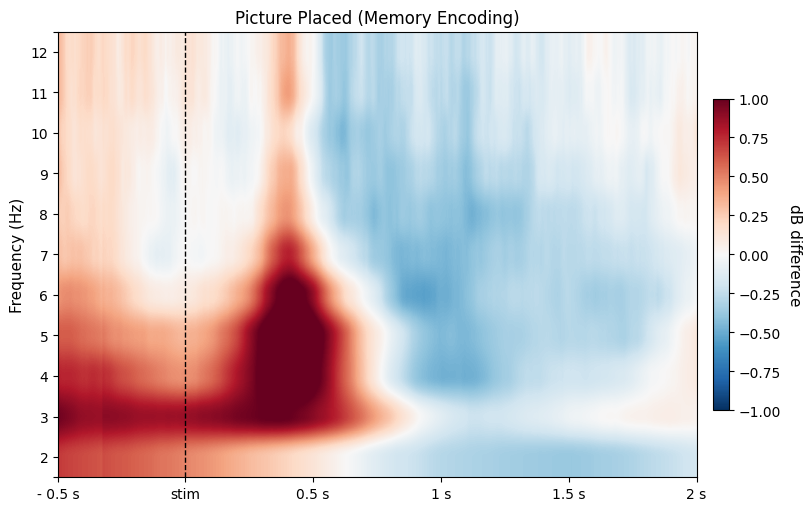

In [11]:
custom_cbar = False

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 5), layout='compressed')
        
im = ax.imshow(
    dict_tfr_power_results_total_avg, 
    aspect='auto',
    extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
    origin='lower',
    vmin=-np.max(abs(dict_tfr_power_results_total_avg)) if custom_cbar else -1,
    vmax=np.max(abs(dict_tfr_power_results_total_avg)) if custom_cbar else 1,
    cmap='RdBu_r',
    interpolation='hanning')

title = f'{stimulus} ' + '(Memory Recall)' if stimulus == 'Picture Shown' else f'{stimulus} ' + '(Memory Encoding)'
ax.set_title(title, fontsize=12)
ax.set_ylabel('Frequency (Hz)', fontsize=11)        # only set ylabel for left most plots
ax.set_yticks(yticks, ylabels, fontsize=10)
ax.set_xticks(xticks, xlabels, rotation=0, fontsize=10)

# add line at stimulus onset
ax.axvline(x=255, color='black', linestyle='--', linewidth=1.)

# add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.70, pad=0.01, orientation="vertical")
cbar.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=11)

full_save_path = f"{path_results}/1.6 {stimulus}_tfr_power.png"
fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
print(f"Saved figure at {repr(full_save_path)}")
# plt.close(fig)
plt.show()

# 2. Statistics

- Permutation test (done in the same way as Q2)
- time-frequency window to use for 1D statistical analysis

### 2.1 Load Previous Results

In [18]:
# [IMPORTANT] load data in this cell once to avoid re-running the heavy loading process. 
stimulus = 'Picture Placed'
filename = f"{path_results}/data/1.2 tfr_power_results_{stimulus}.pkl"

# load previously computed time-frequency power for all subjects
with open(filename, 'rb') as f:
    dict_tfr_power_results = pickle.load(f)

# get conditions and subject ids from the loaded results dictionary
subject_ids = list(dict_tfr_power_results.keys())

#################### GET AVERAGES AS DICT ####################
# compute channel average (average each channel across all trials)
dict_tfr_power_results_chan_avg = {s: {} for s in subject_ids}
for subject_id in subject_ids:
    for ch in dict_tfr_power_results[subject_id].keys():
        dict_tfr_power_results_chan_avg[subject_id][ch] = np.mean(list(dict_tfr_power_results[subject_id][ch].values()), axis=0)
            
# compute subject average (average each subject across all channels)
dict_tfr_power_results_subj_avg = {s: {} for s in subject_ids}
for subject_id in subject_ids:
    dict_tfr_power_results_subj_avg[subject_id] = np.mean(list(dict_tfr_power_results_chan_avg[subject_id].values()), axis=0)
        
# compute total average (average across all subjects)
dict_tfr_power_results_total_avg = None
dict_tfr_power_results_total_avg = np.mean(list(dict_tfr_power_results_subj_avg.values()), axis=0)

#################### GET AVERAGES AS ARRAY ####################
# get time-frequency shape
n_frequencies   = dict_tfr_power_results_total_avg.shape[0]
n_timepoints    = dict_tfr_power_results_total_avg.shape[1]

# create array for subject averages
arr_tfr_power_results_subj_avg                  = np.zeros((len(subject_ids), n_frequencies, n_timepoints))
for i, subject_id in enumerate(subject_ids):
    dict_tfr_power_results_subj_avg[subject_id] = np.mean(list(dict_tfr_power_results_chan_avg[subject_id].values()), axis=0)
    arr_tfr_power_results_subj_avg[i]           = dict_tfr_power_results_subj_avg[subject_id]
    
# create array for total average
arr_tfr_power_results_total_avg                 = np.mean(arr_tfr_power_results_subj_avg, axis=0)

# clean up to save memory
del dict_tfr_power_results

### 2.2 Permutation Test

In [19]:
alpha           = 0.05

# ************ STATISTICS ************
df              = len(subject_ids) - 1                                                      # degrees of freedom
threshold       = stats.t.ppf(1 - alpha / 2, df)                                            # divided by 2 for two-tailed test
stat_fun        = lambda x, y: stats.ttest_rel(x, y, axis=0, alternative='two-sided')[0]    # paired two-sample t-test
print(f"Threshold: {threshold}")


# ************ PERMUTATION TEST ************
statistics      = {'T_obs': None, 'clusters': None, 'cluster_p_values': None, 'H0': None}
    
# reshape data to fit permutation function
tfr_data        = arr_tfr_power_results_subj_avg#.reshape(len(subject_ids), -1)
tfr_baseline    = np.zeros_like(tfr_data) # baseline is all zeros (data is already baseline corrected)

# define combined input X to permutation function
X = [tfr_data, tfr_baseline]

T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(
    X,
    threshold=threshold,
    n_permutations=1000, 
    tail=1, 
    n_jobs=-1, 
    seed=23,
    out_type='mask',
    stat_fun=stat_fun)

statistics['T_obs'] = T_obs #.reshape(n_freqs, n_times) # reshape back to time-frequency shape
statistics['clusters'] = clusters
statistics['cluster_p_values'] = cluster_p_values
statistics['H0'] = H0

del X, T_obs, clusters, cluster_p_values, H0
    
    
#********** SAVE STATISTICS RESULTS **********#
filename = f"{path_results}/data/2.2 {stimulus}_stat_permutation_stimulus_vs_baseline.pkl"
with open(filename, 'wb') as f:
    pickle.dump(statistics, f)

Threshold: 2.2281388519649385
stat_fun(H1): min=-5.27092747827383 max=4.692047444825899
Running initial clustering …
Found 4 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

##### Plot

SIGNIFICANT: cluster 1 with p-value 0.012
NOT SIGNIFICANT: cluster 2 with p-value 0.678
NOT SIGNIFICANT: cluster 3 with p-value 0.678
NOT SIGNIFICANT: cluster 4 with p-value 0.673


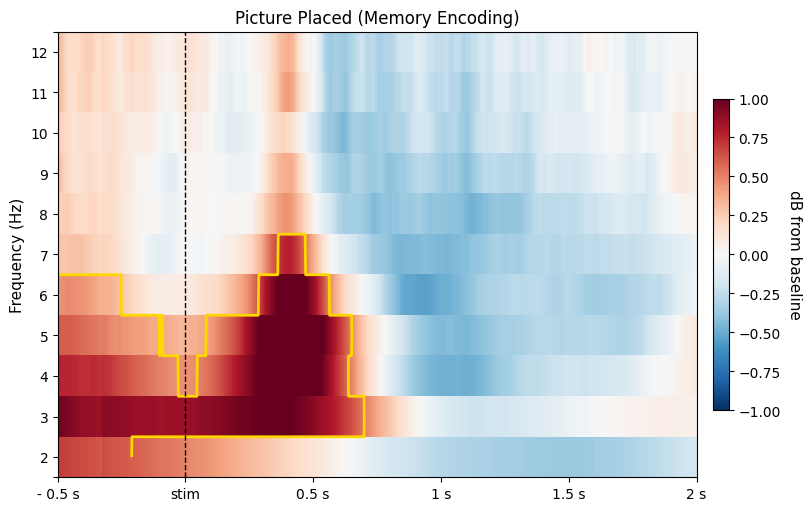

In [20]:
# [INFO] CHANGE IF NEEDED
tfr_data                = arr_tfr_power_results_total_avg
fname_statistics        = f"2.2 {stimulus}_stat_permutation_stimulus_vs_baseline.pkl"
custom_cbar             = False
draw_cluster_contours   = True

# smoothing parameters
factor                  = 5
sigma                   = 0.7
bool_smooth             = False


# load statistics
with open(f"{path_results}/data/{fname_statistics}", 'rb') as f:
    statistics = pickle.load(f)
    

#********** PLOT RESULTS **********#
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), layout='compressed')
    
# get statistics
T_obs               = statistics['T_obs']
clusters            = statistics['clusters']
cluster_p_values    = statistics['cluster_p_values']

# create cluster mask based on p-values
cluster_mask = np.full_like(T_obs, np.nan)
for cid, (c, p_val) in enumerate(zip(clusters, cluster_p_values)):
    if p_val <= alpha:
        print(f"SIGNIFICANT: cluster {cid+1} with p-value {p_val}")
        cluster_mask[c] = T_obs[c]
    else:
        print(f"NOT SIGNIFICANT: cluster {cid+1} with p-value {p_val}")

# get clusters indexes (flattened shape)
idx = np.where(np.isnan(cluster_mask) == False)

if draw_cluster_contours:
    # binary mask
    tfr_plot_mask                   = np.zeros_like(T_obs)
    tfr_plot_mask[idx[0], idx[1]]   = 1
else:
    # time-frequency power for clusters only
    tfr_plot_mask                   = np.full_like(T_obs, np.nan)
    tfr_plot_mask[idx[0], idx[1]]   = tfr_data[idx] # set cluster indexes to tfr_data values
    # tfr_plot_mask       = tfr_plot_mask.reshape(n_frequencies, n_timepoints) # reshape to time-frequency shape
    

# ********* TIME-FREQUENCY POWER *********
if bool_smooth:
    tfr_data       = zoom(tfr_data, factor)
    tfr_plot_mask  = zoom(tfr_plot_mask, factor)
    tfr_data       = gaussian_filter(tfr_data, sigma)
    tfr_plot_mask  = gaussian_filter(tfr_plot_mask, sigma)
        
if draw_cluster_contours:
    im = ax.imshow(
        tfr_data,
        aspect='auto',
        extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
        origin='lower',
        vmin=-np.max(tfr_data) if custom_cbar else -1,
        vmax=np.max(tfr_data) if custom_cbar else 1,
        cmap='RdBu_r',
        interpolation='none'
    )
    ax.contour(
        tfr_plot_mask,
        colors='gold', 
        levels=[0.5], 
        extent=[timepoints[0], timepoints[-1], frequencies[0], frequencies[-1]], 
        linewidths=2.
    )
else:
    ax.imshow(
        tfr_data,
        aspect='auto',
        extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
        origin='lower',
        vmin=-np.max(tfr_data) if custom_cbar else -1,
        vmax=np.max(tfr_data) if custom_cbar else 1,
        cmap='gray',
        interpolation='none',
        # alpha=.5
    )
    im = ax.imshow(
        tfr_plot_mask,
        aspect='auto',
        extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
        origin='lower',
        vmin=-np.max(tfr_data) if custom_cbar else -1,
        vmax=np.max(tfr_data) if custom_cbar else 1,
        cmap='RdBu_r',
        interpolation='none'
    )
    
title = f'{stimulus} ' + '(Memory Recall)' if stimulus == 'Picture Shown' else f'{stimulus} ' + '(Memory Encoding)'
ax.set_title(title, fontsize=12)
ax.set_ylabel('Frequency (Hz)', fontsize=11)
ax.set_yticks(yticks, ylabels, fontsize=10)
ax.set_xticks(xticks, xlabels, rotation=0, fontsize=10)
ax.axvline(x=255, color='black', linestyle='--', linewidth=1.) # stimulus onset


# add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=.7, pad=0.01, orientation="vertical")
cbar.ax.set_ylabel("dB from baseline", rotation=270, labelpad=15, fontsize=11)

# save figures
fig.savefig(f"{path_results}/2.2 {stimulus}_stat_stimulus_vs_baseline_perm_clusters.png", dpi=300, bbox_inches='tight')

# plt.close(fig)
plt.show()

### 2.3 t-test

In [21]:
tfr_data = dict_tfr_power_results_subj_avg

# statistics
alpha           = 0.05

# initialize output from statistics
statistics      = {'t-statistics': None, 'p-values': None, 'clusters': None, 'cluster_labels': None, 'cluster_sizes': None}

# perform permutation test for each condition separately
start_time = time.time()

# construct matrices
t_statistics    = np.zeros((n_frequencies, n_timepoints))     # 11 frequencies, 1280 time points
p_values        = np.zeros((n_frequencies, n_timepoints))     # 11 frequencies, 1280 time points
clusters        = np.zeros((n_frequencies, n_timepoints))     # 11 frequencies, 1280 time points

# iterate over frequencies and time points
for i in range(n_frequencies):
    for j in range(n_timepoints):
        
        sample_cond = []
        # for each combination of frequency and time, store the power values for all subjects and channels
        # this will be used to perform the permutation test
        for subject_id in subject_ids:
            # store power values for each subject's channel average: frequency and time point
            sample_cond.append(tfr_data[subject_id][i, j])
        
        # perform two-sided paired samples t-test
        # note:
        #   - compute t-test for time-frequency power and baseline (zero).
        #   - sample A holds power values for each subject at a specific frequency and time point (all channels have been averaged together).
        #   - sample B is a vector of zeros rerpresenting the baseline, this is because the power data has been baseline corrected.
        # data_to_test = np.append(np.array(sample_cond)[np.newaxis, ...], np.zeros(len(sample_cond))[np.newaxis, ...], axis=0)
        sa = sample_cond
        sb = np.zeros(len(sample_cond))
        res = stats.ttest_rel(a=sa, b=sb, nan_policy='raise', alternative='two-sided', axis=0)
        
        # store results
        t_statistics[i, j]  = res.statistic
        p_values[i, j]      = res.pvalue
        clusters[i, j]      = 1 if res.pvalue <= alpha else 0

# check if clusters were found
if np.isclose(clusters, 0).all():
    print(f"No clusters found.")
    cluster_labels  = np.array([0] * shape[0] * shape[1]).reshape(shape)
    cluster_sizes   = None
else:
    # assign labels to clusters [REMOVE] replaced by ndimage.label(clusters)
    # cluster_labels = npsystat.assign_cluster_labels(clusters, verbose=verbose)
    cluster_labels = ndimage.label(clusters)[0]
    
    if 0 not in cluster_labels:
        print(f"Found {len(np.unique(cluster_labels))} clusters: {np.unique(cluster_labels)}.")
    else:
        print(f"Found {len(np.unique(cluster_labels)[1:])} clusters: {np.unique(cluster_labels)[1:]}.")
    
    # count cluster sizes
    cluster_sizes = npsystat.get_cluster_sizes(t_statistics=t_statistics, cluster_labels=cluster_labels)
        
# store results
statistics['t-statistics'] = t_statistics.tolist()
statistics['p-values'] = p_values.tolist()
statistics['clusters'] = clusters.tolist()
statistics['cluster_labels'] = cluster_labels.tolist()
statistics['cluster_sizes'] = cluster_sizes

print(f"Finished in {(time.time() - start_time):.2f} s\n")
    
#********** SAVE STATISTICS RESULTS **********#
filename = f"{path_results}/data/2.3 {stimulus}_stat_t_test_condition_vs_baseline.json"
with open(filename, 'w') as f:
    print(f"Saving statistics results as {repr(filename)}...")
    json.dump(statistics, f)
    print("Done")

Found 13 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13].
Finished in 4.40 s

Saving statistics results as '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis/data/2.3 Picture Placed_stat_t_test_condition_vs_baseline.json'...
Done


#### plot

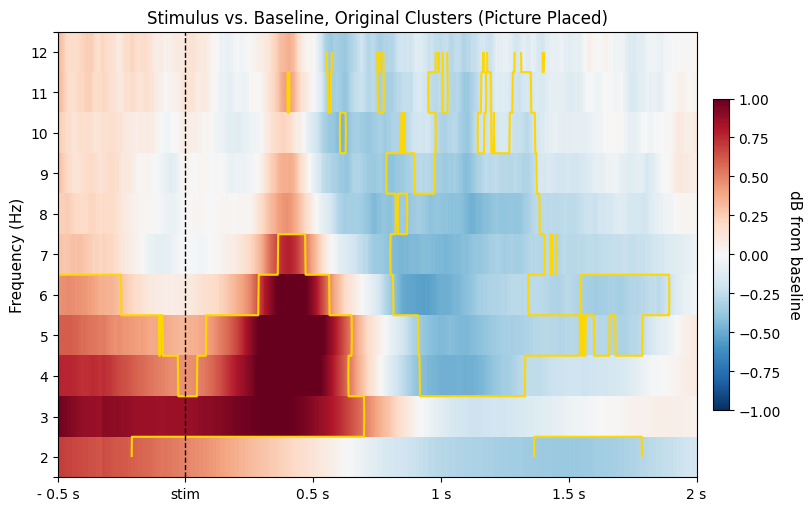

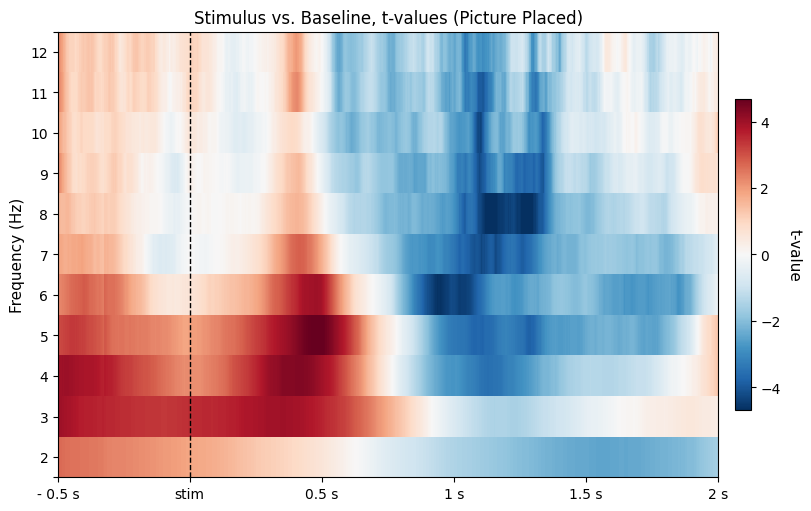

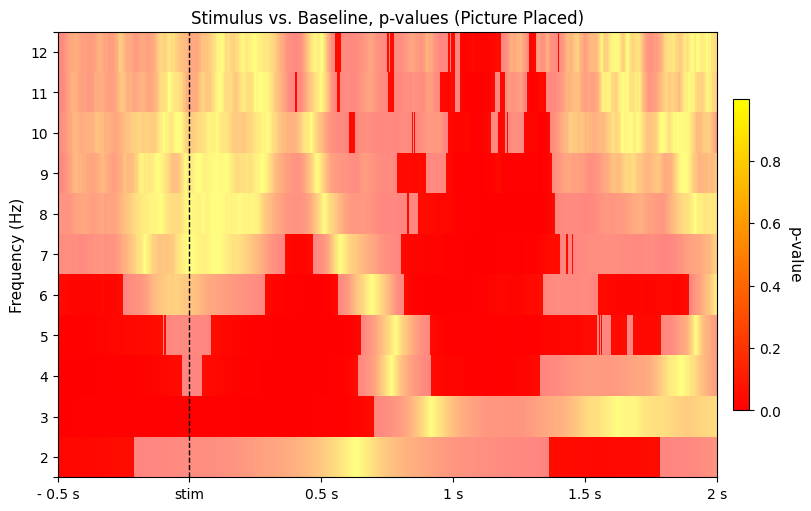

In [22]:
# [INFO] CHANGE IF NEEDED
tfr_data                = dict_tfr_power_results_total_avg
fname_statistics        = f"2.3 {stimulus}_stat_t_test_condition_vs_baseline.json"
custom_cbar             = True # individual color bars (True/False)
draw_cluster_contours   = True

# smoothing parameters
factor                  = 5
sigma                   = 0.7
bool_smooth             = False

# load statistics
with open(f"{path_results}/data/{fname_statistics}", 'r') as f:
    statistics = json.load(f)

# convert to numpy arrays
statistics['t-statistics']      = np.array(statistics['t-statistics'])
statistics['p-values']          = np.array(statistics['p-values'])
statistics['clusters']          = np.array(statistics['clusters'])
statistics['cluster_labels']    = np.array(statistics['cluster_labels'])

#********** PLOT RESULTS **********#
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), layout='compressed')
fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), layout='compressed')
fig3, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), layout='compressed')
    
# get statistics
t_observed = statistics['t-statistics']
p_observed = statistics['p-values']

# find indices where p-value is significant
idx_freqs, idx_time = np.where(p_observed <= alpha)
# create mask for all three plots
tfr_plot_mask   = np.zeros_like(p_observed) if draw_cluster_contours else np.full_like(p_observed, np.nan)
t_plot_mask     = np.full_like(p_observed, np.nan)
p_plot_mask     = np.full_like(p_observed, np.nan)
for f, t in zip(idx_freqs, idx_time):
    tfr_plot_mask[f, t] = 1 if draw_cluster_contours else tfr_data[f, t]
    t_plot_mask[f, t]   = t_observed[f, t]
    p_plot_mask[f, t]   = p_observed[f, t]
    

# ********* TIME-FREQUENCY POWER (original clusters) *********
if bool_smooth:
    tfr_data       = zoom(tfr_data, factor)
    tfr_plot_mask  = zoom(tfr_plot_mask, factor)
    tfr_data       = gaussian_filter(tfr_data, sigma)
    tfr_plot_mask  = gaussian_filter(tfr_plot_mask, sigma)
    
if draw_cluster_contours:
    im1 = ax1.imshow(
        tfr_data,
        aspect='auto',
        extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
        origin='lower',
        # vmin=-np.max(tfr_data) if custom_cbar else -1,
        # vmax=np.max(tfr_data) if custom_cbar else 1,
        vmin=-1,
        vmax=1,
        cmap='RdBu_r',
        interpolation='none'
    )
    ax1.contour(
        tfr_plot_mask,
        colors='gold', 
        levels=[0.5], 
        extent=[timepoints[0], timepoints[-1], frequencies[0], frequencies[-1]], 
        linewidths=1.5
    )
else:
    ax1.imshow(
        tfr_data,
        aspect='auto',
        extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
        origin='lower',
        vmin=-np.max(tfr_data) if custom_cbar else -1,
        vmax=np.max(tfr_data) if custom_cbar else 1,
        cmap='gray',
        interpolation='none',
        # alpha=.5
    )
    im1 = ax1.imshow(
        tfr_plot_mask,
        aspect='auto',
        extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
        origin='lower',
        vmin=-np.max(tfr_data) if custom_cbar else -1,
        vmax=np.max(tfr_data) if custom_cbar else 1,
        cmap='RdBu_r',
        interpolation='none'
    )
ax1.set_title(f"Stimulus vs. Baseline, Original Clusters ({stimulus})", fontsize=12)
ax1.set_ylabel('Frequency (Hz)', fontsize=11) # only set ylabel for left most plots
ax1.set_yticks(yticks, ylabels, fontsize=10)
ax1.set_xticks(xticks, xlabels, rotation=0, fontsize=10)
ax1.axvline(x=255, color='black', linestyle='--', linewidth=1.) # add line at stimulus onset

# ********* T-VALUE REPRESENTATION *********
im2 = ax2.imshow(
    t_observed,
    aspect='auto',
    extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
    origin='lower',
    vmin=-np.max(t_observed) if custom_cbar else -1,
    vmax=np.max(t_observed) if custom_cbar else 1,
    cmap='RdBu_r',
    interpolation='none',
)
ax2.set_title(f"Stimulus vs. Baseline, t-values ({stimulus})", fontsize=12)
ax2.set_ylabel('Frequency (Hz)', fontsize=11) # only set ylabel for left most plots
ax2.set_yticks(yticks, ylabels, fontsize=10)
ax2.set_xticks(xticks, xlabels, rotation=0, fontsize=10)
ax2.axvline(x=255, color='black', linestyle='--', linewidth=1.) # add line at stimulus onset

# ********* P-VALUE REPRESENTATION *********
ax3.imshow(
    p_observed,
    aspect='auto',
    extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
    origin='lower',
    vmin=0,
    vmax=np.max(p_observed) if custom_cbar else 1,
    cmap='autumn',
    interpolation='none',
    alpha=.5
)
im3 = ax3.imshow(
    p_plot_mask,
    aspect='auto',
    extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
    origin='lower',
    vmin=0,
    vmax=np.max(p_observed) if custom_cbar else 1,
    cmap='autumn',
    interpolation='none'
)
ax3.set_title(f"Stimulus vs. Baseline, p-values ({stimulus})", fontsize=12)
ax3.set_ylabel('Frequency (Hz)', fontsize=11) # only set ylabel for left most plots
ax3.set_yticks(yticks, ylabels, fontsize=10)
ax3.set_xticks(xticks, xlabels, rotation=0, fontsize=10)
ax3.axvline(x=255, color='black', linestyle='--', linewidth=1.) # add line at stimulus onset


# add individual colorbars for plots in figure
cbar1 = plt.colorbar(im1, ax=ax1, shrink=.7, pad=0.01, orientation="vertical")
cbar2 = plt.colorbar(im2, ax=ax2, shrink=.7, pad=0.01, orientation="vertical")
cbar3 = plt.colorbar(im3, ax=ax3, shrink=.7, pad=0.01, orientation="vertical")
cbar1.ax.set_ylabel("dB from baseline", rotation=270, labelpad=15, fontsize=11)
cbar2.ax.set_ylabel("t-value", rotation=270, labelpad=15, fontsize=11)
cbar3.ax.set_ylabel("p-value", rotation=270, labelpad=15, fontsize=11)

# add figure titles
# fig1.suptitle(f"Stimulus vs. Baseline, Original Clusters ({stimulus})", fontsize=14, y=1.05, x=.49)
# fig2.suptitle(f"Stimulus vs. Baseline, t-values ({stimulus})", fontsize=14, y=1.05, x=.49)
# fig3.suptitle(f"Stimulus vs. Baseline, p-values ({stimulus})", fontsize=14, y=1.05, x=.49)

# save figures
fig1.savefig(f"{path_results}/2.3 {stimulus}_stat_stimulus_vs_baseline_org_clusters.png", dpi=300, bbox_inches='tight')
fig2.savefig(f"{path_results}/2.3 {stimulus}_stat_stimulus_vs_baseline_t_values.png", dpi=300, bbox_inches='tight')
fig3.savefig(f"{path_results}/2.3 {stimulus}_stat_stimulus_vs_baseline_p_values.png", dpi=300, bbox_inches='tight')

# plt.close(fig)
plt.show()

# 3. Window-of-Interest

### 3.0 Helper Functions

In [27]:
def cut_tfr_data(tfr_data_condition, stimulus_onset, fs, freq_start, freq_end, time_start, time_end):
    """cut_tfr_data Cut time-frequency power data for a specific time-frequency range and average area.

    Args:
        tfr_data_condition (2darray): Time-frequency power data to cut.
        stimulus_onset (int): The stimulus onset time in time points.
        fs (int): The sampling frequency in Hz.
        freq_start (float): The start frequency of the range to cut the time-frequency power data in Hz.
        freq_end (float): The end frequency of the range to cut the time-frequency power data in Hz.
        time_start (float): The start time of the range to cut the time-frequency power data in seconds.
        time_end (float): The end time of the range to cut the time-frequency power data in seconds.

    Returns:
        tfr_data_condition_cut (float): The average time-frequency power data for the specified range.
        freq_start_idx (int): The start frequency index of the range.
        freq_end_idx (int): The end frequency index of the range.
        time_start_idx (int): The start time index of the range.
        time_end_idx (int): The end time index of the range.
    """    
    # convert frequency range to indices
    freq_start_idx = np.where(frequencies == freq_start)[0][0].astype(int)
    freq_end_idx = np.where(frequencies == freq_end)[0][0].astype(int) + 1

    # convert time range to indices with respect to the stimulus onset
    time_start_idx = np.floor(stimulus_onset + (time_start * fs)).astype(int)
    time_start_idx = 0 if time_start_idx < 0 else time_start_idx
    time_end_idx = np.floor(stimulus_onset + (time_end * fs)).astype(int)
    
    # cut time-frequency power data and average flattened array
    tfr_data_condition_cut = np.mean(tfr_data_condition[freq_start_idx:freq_end_idx, time_start_idx:time_end_idx], axis=None)
    return tfr_data_condition_cut, freq_start_idx, freq_end_idx, time_start_idx, time_end_idx

def barplot_annotate_brackets(ax, num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)
    
    ax.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    ax.text(*mid, text, **kwargs)
    

def compute_standard_error(tfr_data_subs_avg, subject_ids, stimulus_onset, fs, freq_start, freq_end, time_start, time_end):
    """compute_standard_error Computes the standard error for each condition across subjects.

    Args:
        tfr_data_subs_avg (dict): A dictionary containing the time-frequency power data for all subjects.
        subject_ids (list): A list of all subjects.
        stimulus_onset (int): The stimulus onset time in time points.
        fs (int): The sampling frequency in Hz.
        freq_start (float): The start frequency of the range to cut the time-frequency power data.
        freq_end (float): The end frequency of the range to cut the time-frequency power data.
        time_start (float): The start time of the range to cut the time-frequency power data.
        time_end (float): The end time of the range to cut the time-frequency power data.

    Returns:
        stderror (dict): A dict containing the standard error for each condition.
    """
    means = []
    for i, sub_id in enumerate(subject_ids):
        # cut time-frequency power data for each subject and average flattened array
        # check if tfr_data_subs_avg is array
        if isinstance(tfr_data_subs_avg, np.ndarray):
            tfr_data_window_avg, _, _, _, _ = cut_tfr_data(tfr_data_subs_avg[i], stimulus_onset, fs, freq_start, freq_end, time_start, time_end)
        else:
            tfr_data_window_avg, _, _, _, _ = cut_tfr_data(tfr_data_subs_avg[sub_id], stimulus_onset, fs, freq_start, freq_end, time_start, time_end)
        means.append(tfr_data_window_avg)
    # compute standard error
    stderror = np.std(means, axis=0) / np.sqrt(len(means))
    return stderror


def get_all_subjects_cut_data(tfr_data_subjects_avg, subject_ids, condition, stimulus_onset, fs, freq_start, freq_end, time_start, time_end):
    """get_all_subjects_cut_data Get time-frequency power data for all subjects individually in a condition.

    Args:
        tfr_data_subjects_avg (dict): A dictionary containing the time-frequency power data for each subject.
        subject_ids (list): A list of subject ids to get the time-frequency power data for.
        condition (str): The condition to get the time-frequency power data for.
        stimulus_onset (int): The stimulus onset time in time points.
        fs (int): The sampling frequency in Hz.
        freq_start (float): The start frequency of the range to cut the time-frequency power data.
        freq_end (float): The end frequency of the range to cut the time-frequency power data.
        time_start (float): The start time of the range to cut the time-frequency power data.
        time_end (float): The end time of the range to cut the time-frequency power data.

    Returns:
        dict: A dictionary containing the time-frequency power data for all subjects in a condition.
    """    
    tfr_data_cut_subs = {s: None for s in subject_ids}
    
    for sub_id in subject_ids:
        # cut time-frequency power data for each subject and average flattened array
        tfr_data_cut_subs[sub_id], _, _, _, _ = cut_tfr_data(tfr_data_subjects_avg[condition][sub_id], stimulus_onset, fs, freq_start, freq_end, time_start, time_end)

    return tfr_data_cut_subs


def load_results(filename):
    # load previously computed time-frequency power for all subjects
    with open(filename, 'rb') as f:
        dict_tfr_power_results = pickle.load(f)

    # get conditions and subject ids from the loaded results dictionary
    subject_ids = list(dict_tfr_power_results.keys())

    #################### GET AVERAGES AS DICT ####################
    # compute channel average (average each channel across all trials)
    dict_tfr_power_results_chan_avg = {s: {} for s in subject_ids}
    for subject_id in subject_ids:
        for ch in dict_tfr_power_results[subject_id].keys():
            dict_tfr_power_results_chan_avg[subject_id][ch] = np.mean(list(dict_tfr_power_results[subject_id][ch].values()), axis=0)
                
    # compute subject average (average each subject across all channels)
    dict_tfr_power_results_subj_avg = {s: {} for s in subject_ids}
    for subject_id in subject_ids:
        dict_tfr_power_results_subj_avg[subject_id] = np.mean(list(dict_tfr_power_results_chan_avg[subject_id].values()), axis=0)
            
    # compute total average (average across all subjects)
    dict_tfr_power_results_total_avg = None
    dict_tfr_power_results_total_avg = np.mean(list(dict_tfr_power_results_subj_avg.values()), axis=0)

    #################### GET AVERAGES AS ARRAY ####################
    # get time-frequency shape
    n_frequencies   = dict_tfr_power_results_total_avg.shape[0]
    n_timepoints    = dict_tfr_power_results_total_avg.shape[1]

    # create array for subject averages
    arr_tfr_power_results_subj_avg                  = np.zeros((len(subject_ids), n_frequencies, n_timepoints))
    for i, subject_id in enumerate(subject_ids):
        dict_tfr_power_results_subj_avg[subject_id] = np.mean(list(dict_tfr_power_results_chan_avg[subject_id].values()), axis=0)
        arr_tfr_power_results_subj_avg[i]           = dict_tfr_power_results_subj_avg[subject_id]
        
    # create array for total average
    arr_tfr_power_results_total_avg                 = np.mean(arr_tfr_power_results_subj_avg, axis=0)

    # clean up to save memory
    del dict_tfr_power_results
    
    return arr_tfr_power_results_total_avg, arr_tfr_power_results_subj_avg, subject_ids

### 3.1 Cut Window-of-Interest

In [24]:
stimulus_list       = ['Picture Shown', 'Picture Placed']

dict_tfr_stimulus_total_avg = {}
dict_tfr_stimulus_subj_avg  = {}
for stimulus in stimulus_list:
    filename = f"{path_results}/data/1.2 tfr_power_results_{stimulus}.pkl"
    dict_tfr_stimulus_total_avg[stimulus], dict_tfr_stimulus_subj_avg[stimulus], subject_ids = load_results(filename)

Frequency range:	3 - 6 Hz
Time range:		0.25 - 0.75 s
Frequency range:	3 - 6 Hz
Time range:		0.3 - 0.55 s


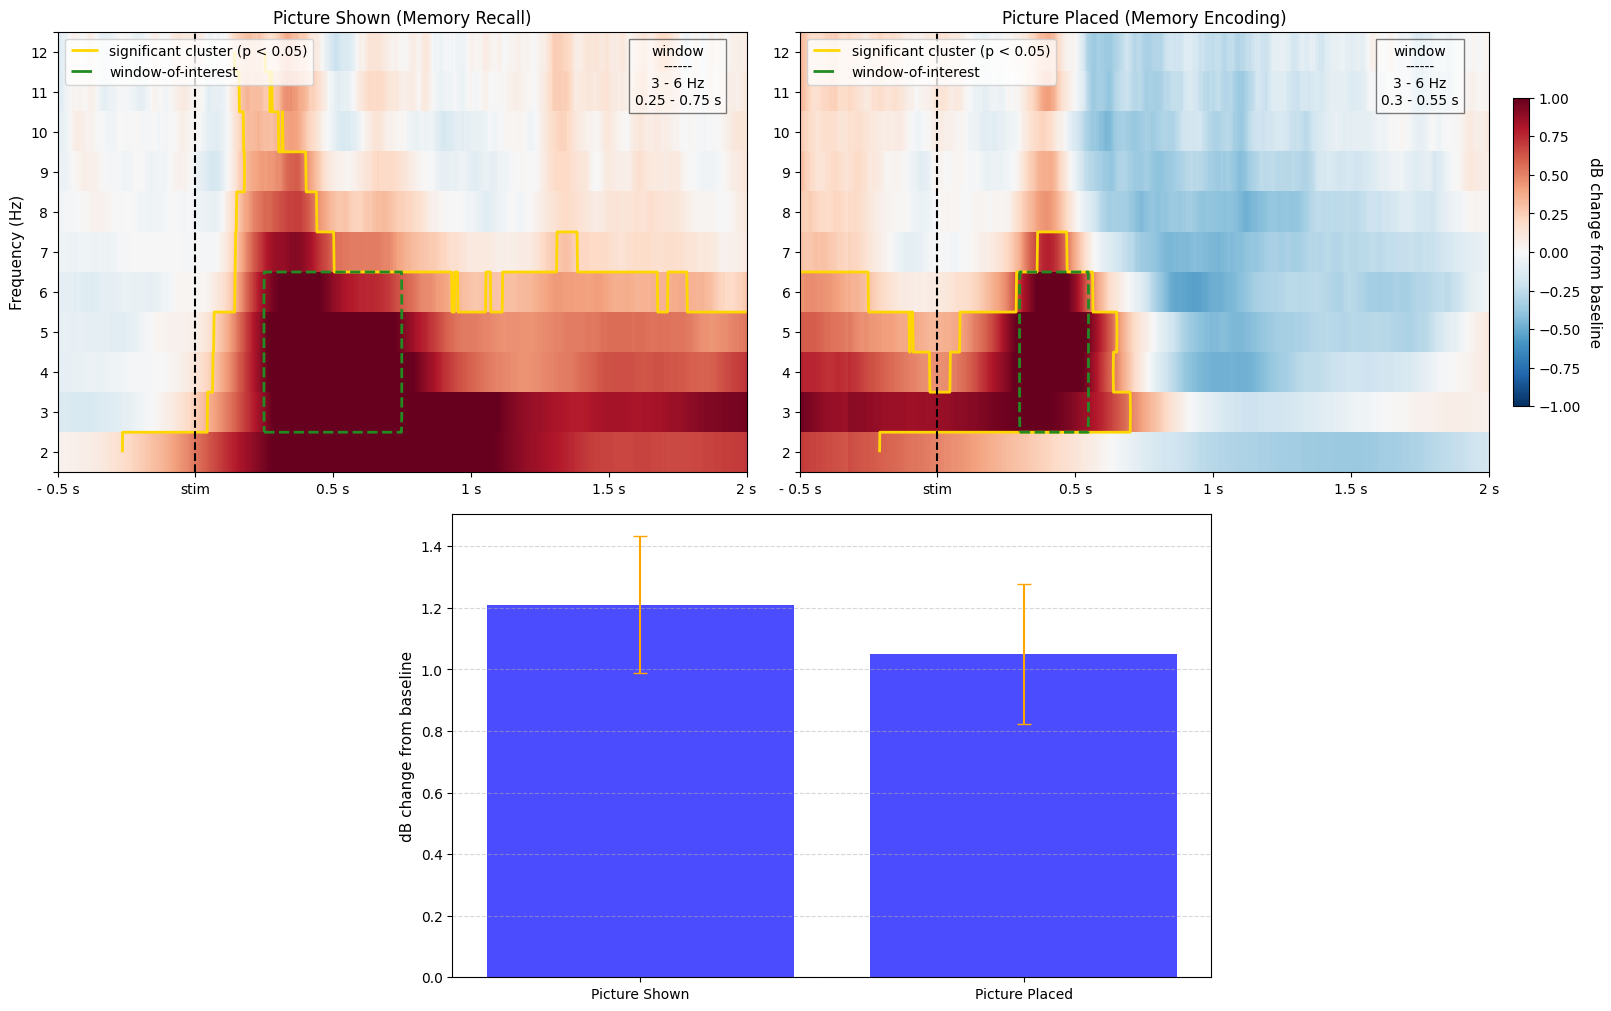

In [36]:
stimulus_list       = ['Picture Shown', 'Picture Placed']
bool_save           = True
#   - freq_start, freq_end: frequency range to cut data from
#   - time_start, time_end: time range to cut data from
# picture shown
freq_start_picshown, freq_end_picshown    = 3, 6      # frequency range to cut (in Hz)
time_start_picshown, time_end_picshown    = 0.25, 0.75   # time range to cut (in seconds)
# picture placed
freq_start_picplace, freq_end_picplace    = 3, 6      # frequency range to cut (in Hz)
time_start_picplace, time_end_picplace    = 0.3, 0.55   # time range to cut (in seconds)

# list of frequency and time ranges
freq_ranges = [(freq_start_picshown, freq_end_picshown), (freq_start_picplace, freq_end_picplace)]
time_ranges = [(time_start_picshown, time_end_picshown), (time_start_picplace, time_end_picplace)]

# common parameters
individ_cbars       = False
fs                  = 512
stimulus_onset      = 255

################# GET PERMUTATION CLUSTER MASKS #################
# load permutation statistics to get cluster mask
cluster_masks = {s: None for s in stimulus_list}
for stimulus in stimulus_list:
    fname_statistics = f"2.2 {stimulus}_stat_permutation_stimulus_vs_baseline.pkl"
    with open(f"{path_results}/data/{fname_statistics}", 'rb') as f:
        statistics = pickle.load(f)
    # get statistics
    T_obs               = statistics['T_obs']
    clusters            = statistics['clusters']
    cluster_p_values    = statistics['cluster_p_values']
    # create cluster mask based on p-values
    cluster_mask = np.full_like(T_obs, np.nan)
    for cid, (c, p_val) in enumerate(zip(clusters, cluster_p_values)):
        if p_val <= alpha:
            cluster_mask[c] = T_obs[c]
        else:
            pass
    # get clusters indexes (flattened shape)
    idx = np.where(np.isnan(cluster_mask) == False)
    # binary mask
    tfr_plot_mask                   = np.zeros_like(T_obs)
    tfr_plot_mask[idx[0], idx[1]]   = 1
    cluster_masks[stimulus] = tfr_plot_mask
    
################# PLOT #################
# initialize figure
fig = plt.figure(figsize=(16, 10), layout="constrained")
subfigs = fig.subfigures(nrows=2, ncols=1)
# FIGURE 1: time-frequency power (individual stimulus)
axs0 = subfigs[0].subplots(nrows=1, ncols=len(stimulus_list))
axs0 = axs0.flatten()
# FIGURE 2: bar plot
gs_kw = dict(width_ratios=[0.5, 1, 0.5])
axs1 = subfigs[1].subplots(nrows=1, ncols=3, gridspec_kw=gs_kw)
axs1 = axs1.flatten()
axs1[0].axis('off')
axs1[-1].axis('off')
axs1 = axs1[1:-1]

# initialise dictionary to store cut data and errors
tfr_data_window_total   = {s: None for s in stimulus_list}
stderror                = {s: None for s in stimulus_list}
for i, (stimulus, (freq_start, freq_end), (time_start, time_end)) in enumerate(zip(stimulus_list, freq_ranges, time_ranges)):
    print(f"Frequency range:\t{freq_start} - {freq_end} Hz")
    print(f"Time range:\t\t{time_start} - {time_end} s")

    # get time-frequency power data
    tfr_data_total      = dict_tfr_stimulus_total_avg[stimulus]
    tfr_data_subjects   = dict_tfr_stimulus_subj_avg[stimulus]
    
    # cut window-of-interest
    tfr_data_window_total[stimulus], freq_start_idx, freq_end_idx, time_start_idx, time_end_idx = cut_tfr_data(tfr_data_total, stimulus_onset, fs, freq_start, freq_end, time_start, time_end)
    
    # compute standard error
    stderror[stimulus] = compute_standard_error(tfr_data_subjects, subject_ids, stimulus_onset, fs, freq_start, freq_end, time_start, time_end)
    
    # create a binary mask to draw contour around the window-of-interest
    mask = np.zeros_like(tfr_data_total)
    mask[freq_start_idx:freq_end_idx, time_start_idx:time_end_idx] = 1
    
    # ****** PLOT INDIVIDUAL STIMULUS ****** #
    im0 = axs0[i].imshow(
        tfr_data_total, 
        extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
        vmax=np.max(tfr_data_total) if individ_cbars else 1,
        vmin=-np.max(tfr_data_total) if individ_cbars else -1,
        aspect='auto', 
        origin='lower', 
        cmap='RdBu_r', 
        interpolation='none'
        )
    # plot contour around significant permutation cluster
    cs1 = axs0[i].contour(
        cluster_masks[stimulus], 
        colors='gold',
        levels=[0.5], 
        extent=[timepoints[0], timepoints[-1], frequencies[0], frequencies[-1]], 
        linewidths=2
        )
    # plot contour around window-of-interest
    cs2 = axs0[i].contour(
        mask, 
        colors='forestgreen',
        levels=[0.5], 
        extent=[timepoints[0], timepoints[-1], frequencies[0], frequencies[-1]], 
        linewidths=2,
        linestyles='dashed'
        )
    title = f'{stimulus}' + ' (Memory Recall)' if stimulus == 'Picture Shown' else f'{stimulus}' + ' (Memory Encoding)'
    axs0[i].set_title(title, fontsize=12)
    axs0[0].set_ylabel("Frequency (Hz)", fontsize=11)
    axs0[i].set_yticks(yticks, ylabels, fontsize=10)
    axs0[i].set_xticks(xticks, xlabels, rotation=0, fontsize=10)
    axs0[i].axvline(x=stimulus_onset, color='black', linestyle='--', linewidth=1.5)
    text = f"window\n------\n{freq_start} - {freq_end} Hz\n{time_start} - {time_end} s"
    axs0[i].text(0.9, 0.9, text, fontsize=10, ha='center', va='center', transform=axs0[i].transAxes, color='black', bbox=dict(facecolor='white', alpha=0.5))
    h1, _ = cs1.legend_elements()
    h2, _ = cs2.legend_elements()
    axs0[i].legend([h1[0], h2[0]], ['significant cluster (p < 0.05)', 'window-of-interest'], loc='upper left', fontsize=10)
    
    # add individual colorbars for plots in figure
    if individ_cbars:
        cbar0 = plt.colorbar(im0, ax=axs0[i], shrink=.7, pad=0.01, orientation="vertical")
        if i == len(stimulus)-1: cbar0.ax.set_ylabel("dB change from baseline", rotation=270, labelpad=15, fontsize=11)

# add common colorbar for plots in figure
if not individ_cbars:
    cbar0 = plt.colorbar(im0, ax=axs0.ravel().tolist(), shrink=.7, pad=0.01, orientation="vertical")
    cbar0.ax.set_ylabel("dB change from baseline", rotation=270, labelpad=15, fontsize=11)

# ****** BAR PLOT ****** #
se          = [stderror[s] for s in stimulus_list]
bars        = stimulus_list
heights     = [tfr_data_window_total[s] for s in stimulus_list]

# 1st plot only bar and error
axs1[0].bar(
    bars,
    heights,
    yerr=se,
    capsize=5,
    color='blue',
    ecolor='orange',
    alpha=0.7)
axs1[0].set_ylabel("dB change from baseline", fontsize=11)
axs1[0].grid(axis='y', linestyle='--', alpha=0.5)


# save figure
if bool_save:
    fig.savefig(f"{path_results}/3.1 window-of-interest.png", dpi=300, bbox_inches='tight')
plt.show()

# save window-of-interest data for both stimulus
if bool_save:
    for stimulus in stimulus_list:
        with open(f"{path_results}/data/3.1 {stimulus}_window___{freq_start}-{freq_end}_Hz___{time_start}-{time_end}_s___.pkl", 'wb') as f:
            pickle.dump(tfr_data_window_total[stimulus], f)